# Train Frontend Model with 17 Features
This notebook trains an Isolation Forest model using only the 17 features provided by the frontend.

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import joblib
import optuna

## Load and Preprocess Data

In [12]:
# Load training data
data = pd.read_csv("./dataset/KDDTrain+.txt")
df = data.copy()

# Define column names
columns = (['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot','num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root','num_file_creations','num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count','dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate','dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','attack','level'])
df.columns = columns

print(f"✅ Data loaded with shape: {df.shape}")

✅ Data loaded with shape: (125972, 43)


In [13]:
# Convert attack column to binary (normal/attack)
attack_n = []
for i in df.attack:
    if i == 'normal':
        attack_n.append("normal")
    else:
        attack_n.append("attack")
df['attack'] = attack_n

# Scale numeric features
num = ['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment',
       'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
       'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
       'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'dst_host_count',
       'dst_host_srv_count', 'level']

scaler = StandardScaler()
df[num] = scaler.fit_transform(df[num])

# Encode attack column to binary
mapping = {"normal":0, "attack":1}
df["attack"] = df["attack"].map(mapping)

print("✅ Attack column encoded to binary")

✅ Attack column encoded to binary


In [14]:
# Encode categorical features
cols_to_onehot = ['flag','protocol_type']
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_features = encoder.fit_transform(df[cols_to_onehot])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(cols_to_onehot), index=df.index)
df = df.drop(columns=cols_to_onehot)
df = pd.concat([df, encoded_df], axis=1)

# Frequency encoding for service
freq_encoding = df['service'].value_counts(normalize=True)
df['service'] = df['service'].map(freq_encoding)

print("✅ Categorical features encoded")

✅ Categorical features encoded


In [15]:
# Prepare X and y
X = df.drop(columns=["attack"])
y = df["attack"]

# Train ONLY on normal data
X_train = X[y == 0]
y_train = y[y == 0]

# Split into train and validation
X_train, X_val, _, _ = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Test set contains both normal and anomalies
X_test = X
y_test = y

print(f"✅ Dataset prepared")
print(f"   Train: {X_train.shape}")
print(f"   Val: {X_val.shape}")
print(f"   Test: {X_test.shape}")

✅ Dataset prepared
   Train: (53873, 54)
   Val: (13469, 54)
   Test: (125972, 54)


## Train Frontend Model (17 Features)

In [16]:
# Define the 17 features from frontend
frontend_features = [
    'srv_count', 'service', 'dst_host_srv_count', 'dst_host_same_srv_rate',
    'count', 'dst_host_count', 'rerror_rate', 'logged_in', 'flag_SF',
    'srv_rerror_rate', 'protocol_type_tcp', 'dst_host_srv_rerror_rate',
    'dst_host_rerror_rate', 'src_bytes', 'dst_bytes', 'dst_host_same_src_port_rate',
    'protocol_type_udp'
]

print("="*60)
print("🎯 TRAINING MODEL WITH FRONTEND FEATURES ONLY")
print("="*60)
print(f"\nFrontend Features ({len(frontend_features)}):")
for i, feat in enumerate(frontend_features, 1):
    print(f"  {i:2d}. {feat}")

# Create datasets with frontend features
X_frontend = X[frontend_features]
X_train_frontend = X_train[frontend_features]
X_val_frontend = X_val[frontend_features]
X_test_frontend = X_test[frontend_features]

print(f"\n📊 Dataset Shapes:")
print(f"   Training: {X_train_frontend.shape}")
print(f"   Validation: {X_val_frontend.shape}")
print(f"   Test: {X_test_frontend.shape}")

🎯 TRAINING MODEL WITH FRONTEND FEATURES ONLY

Frontend Features (17):
   1. srv_count
   2. service
   3. dst_host_srv_count
   4. dst_host_same_srv_rate
   5. count
   6. dst_host_count
   7. rerror_rate
   8. logged_in
   9. flag_SF
  10. srv_rerror_rate
  11. protocol_type_tcp
  12. dst_host_srv_rerror_rate
  13. dst_host_rerror_rate
  14. src_bytes
  15. dst_bytes
  16. dst_host_same_src_port_rate
  17. protocol_type_udp

📊 Dataset Shapes:
   Training: (53873, 17)
   Validation: (13469, 17)
   Test: (125972, 17)


In [17]:
# Hyperparameter optimization for frontend features
print(f"\n{'='*60}")
print("🔄 OPTIMIZING HYPERPARAMETERS FOR FRONTEND FEATURES")
print(f"{'='*60}\n")

def objective_frontend(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 400)
    max_samples = trial.suggest_float("max_samples", 0.5, 1.0)
    contamination = trial.suggest_float("contamination", 0.01, 0.2)
    max_features = trial.suggest_float("max_features", 0.5, 1.0)

    model = IsolationForest(
        n_estimators=n_estimators,
        max_samples=max_samples,
        contamination=contamination,
        max_features=max_features,
        random_state=42,
        n_jobs=-1,
    )

    model.fit(X_train_frontend)
    preds = model.predict(X_val_frontend)
    preds = np.where(preds == -1, 1, 0)
    return accuracy_score(np.zeros_like(preds), preds)

study_frontend = optuna.create_study(direction="maximize")
study_frontend.optimize(objective_frontend, n_trials=30, show_progress_bar=True)

print(f"\n✅ Best Parameters: {study_frontend.best_params}")

# Train final model with frontend features
best_params_frontend = study_frontend.best_params
frontend_model = IsolationForest(
    **best_params_frontend,
    random_state=42,
    n_jobs=-1
)

frontend_model.fit(X_train_frontend)
print("✅ Model trained successfully with frontend features!")

[I 2026-02-02 14:48:51,084] A new study created in memory with name: no-name-bd6b084f-9c22-49ec-a685-a0b25ed4adab



🔄 OPTIMIZING HYPERPARAMETERS FOR FRONTEND FEATURES



Best trial: 0. Best value: 0.852328:   3%|▎         | 1/30 [00:05<02:28,  5.12s/it]

[I 2026-02-02 14:48:56,202] Trial 0 finished with value: 0.8523275670057169 and parameters: {'n_estimators': 368, 'max_samples': 0.8828622067615479, 'contamination': 0.1449845349621514, 'max_features': 0.8497738189560811}. Best is trial 0 with value: 0.8523275670057169.


Best trial: 1. Best value: 0.937783:   7%|▋         | 2/30 [00:09<02:15,  4.85s/it]

[I 2026-02-02 14:49:00,862] Trial 1 finished with value: 0.9377830573910461 and parameters: {'n_estimators': 365, 'max_samples': 0.6825326087661403, 'contamination': 0.05871883683686525, 'max_features': 0.8700386798225499}. Best is trial 1 with value: 0.9377830573910461.


Best trial: 2. Best value: 0.976019:  10%|█         | 3/30 [00:11<01:32,  3.42s/it]

[I 2026-02-02 14:49:02,594] Trial 2 finished with value: 0.976019006607766 and parameters: {'n_estimators': 129, 'max_samples': 0.8419894643839139, 'contamination': 0.023879188999410526, 'max_features': 0.6621729394145859}. Best is trial 2 with value: 0.976019006607766.


Best trial: 2. Best value: 0.976019:  13%|█▎        | 4/30 [00:12<01:01,  2.37s/it]

[I 2026-02-02 14:49:03,357] Trial 3 finished with value: 0.8206993837701388 and parameters: {'n_estimators': 57, 'max_samples': 0.7278203986868848, 'contamination': 0.17593242563114017, 'max_features': 0.7019683304430889}. Best is trial 2 with value: 0.976019006607766.


Best trial: 2. Best value: 0.976019:  17%|█▋        | 5/30 [00:15<01:03,  2.54s/it]

[I 2026-02-02 14:49:06,199] Trial 4 finished with value: 0.8246343455341896 and parameters: {'n_estimators': 239, 'max_samples': 0.7369253546325581, 'contamination': 0.17040710688837948, 'max_features': 0.9198176238175246}. Best is trial 2 with value: 0.976019006607766.


Best trial: 5. Best value: 0.98374:  20%|██        | 6/30 [00:17<01:03,  2.64s/it] 

[I 2026-02-02 14:49:09,026] Trial 5 finished with value: 0.9837404410126959 and parameters: {'n_estimators': 185, 'max_samples': 0.6134054259036581, 'contamination': 0.015314747827774032, 'max_features': 0.9807686665354786}. Best is trial 5 with value: 0.9837404410126959.


Best trial: 5. Best value: 0.98374:  23%|██▎       | 7/30 [00:20<01:01,  2.68s/it]

[I 2026-02-02 14:49:11,788] Trial 6 finished with value: 0.9241963026208331 and parameters: {'n_estimators': 176, 'max_samples': 0.5975520095520289, 'contamination': 0.07222010531981067, 'max_features': 0.5411027578530938}. Best is trial 5 with value: 0.9837404410126959.


Best trial: 5. Best value: 0.98374:  27%|██▋       | 8/30 [00:22<00:51,  2.34s/it]

[I 2026-02-02 14:49:13,417] Trial 7 finished with value: 0.8622020936966367 and parameters: {'n_estimators': 89, 'max_samples': 0.6212671583580068, 'contamination': 0.1351424177748506, 'max_features': 0.8913857834288577}. Best is trial 5 with value: 0.9837404410126959.


Best trial: 5. Best value: 0.98374:  30%|███       | 9/30 [00:25<00:51,  2.45s/it]

[I 2026-02-02 14:49:16,103] Trial 8 finished with value: 0.7972381023090058 and parameters: {'n_estimators': 176, 'max_samples': 0.6265521911340415, 'contamination': 0.199324300496571, 'max_features': 0.5382047973665418}. Best is trial 5 with value: 0.9837404410126959.


Best trial: 5. Best value: 0.98374:  33%|███▎      | 10/30 [00:25<00:39,  1.97s/it]

[I 2026-02-02 14:49:16,989] Trial 9 finished with value: 0.8445318880392011 and parameters: {'n_estimators': 55, 'max_samples': 0.6507191881920313, 'contamination': 0.1520226756330985, 'max_features': 0.79945988837266}. Best is trial 5 with value: 0.9837404410126959.


Best trial: 10. Best value: 0.986562:  37%|███▋      | 11/30 [00:29<00:48,  2.56s/it]

[I 2026-02-02 14:49:20,908] Trial 10 finished with value: 0.9865617343529587 and parameters: {'n_estimators': 276, 'max_samples': 0.506550918323123, 'contamination': 0.012739653159965447, 'max_features': 0.9405717126984112}. Best is trial 10 with value: 0.9865617343529587.


Best trial: 10. Best value: 0.986562:  40%|████      | 12/30 [00:32<00:49,  2.74s/it]

[I 2026-02-02 14:49:24,038] Trial 11 finished with value: 0.9860420224218576 and parameters: {'n_estimators': 272, 'max_samples': 0.5029521312739771, 'contamination': 0.01379755521364219, 'max_features': 0.983528660241875}. Best is trial 10 with value: 0.9865617343529587.


Best trial: 10. Best value: 0.986562:  43%|████▎     | 13/30 [00:35<00:47,  2.80s/it]

[I 2026-02-02 14:49:26,976] Trial 12 finished with value: 0.9486970079441681 and parameters: {'n_estimators': 285, 'max_samples': 0.5099325700831893, 'contamination': 0.04958169161986041, 'max_features': 0.9955680017988545}. Best is trial 10 with value: 0.9865617343529587.


Best trial: 10. Best value: 0.986562:  47%|████▋     | 14/30 [00:39<00:46,  2.91s/it]

[I 2026-02-02 14:49:30,155] Trial 13 finished with value: 0.9009577548444576 and parameters: {'n_estimators': 297, 'max_samples': 0.5051998878706059, 'contamination': 0.09750477711350339, 'max_features': 0.9640471251311565}. Best is trial 10 with value: 0.9865617343529587.


Best trial: 10. Best value: 0.986562:  50%|█████     | 15/30 [00:42<00:44,  2.97s/it]

[I 2026-02-02 14:49:33,256] Trial 14 finished with value: 0.963471675699755 and parameters: {'n_estimators': 307, 'max_samples': 0.9995185364306064, 'contamination': 0.03556486905248846, 'max_features': 0.7861250438742262}. Best is trial 10 with value: 0.9865617343529587.


Best trial: 10. Best value: 0.986562:  53%|█████▎    | 16/30 [00:45<00:42,  3.06s/it]

[I 2026-02-02 14:49:36,531] Trial 15 finished with value: 0.9104610587274482 and parameters: {'n_estimators': 251, 'max_samples': 0.5400226324281887, 'contamination': 0.08704727691696477, 'max_features': 0.9081867244170796}. Best is trial 10 with value: 0.9865617343529587.


Best trial: 16. Best value: 0.988047:  57%|█████▋    | 17/30 [00:49<00:45,  3.50s/it]

[I 2026-02-02 14:49:41,047] Trial 16 finished with value: 0.9880466255846759 and parameters: {'n_estimators': 349, 'max_samples': 0.5688581391440547, 'contamination': 0.01079324836531252, 'max_features': 0.6175437830758204}. Best is trial 16 with value: 0.9880466255846759.


Best trial: 16. Best value: 0.988047:  60%|██████    | 18/30 [00:54<00:44,  3.68s/it]

[I 2026-02-02 14:49:45,159] Trial 17 finished with value: 0.8850694186650828 and parameters: {'n_estimators': 332, 'max_samples': 0.5685602783264968, 'contamination': 0.11240817815862134, 'max_features': 0.6238368698639019}. Best is trial 16 with value: 0.9880466255846759.


Best trial: 16. Best value: 0.988047:  63%|██████▎   | 19/30 [00:59<00:44,  4.08s/it]

[I 2026-02-02 14:49:50,174] Trial 18 finished with value: 0.9550820402405524 and parameters: {'n_estimators': 399, 'max_samples': 0.7872065176607376, 'contamination': 0.04208388980041319, 'max_features': 0.6180232968566489}. Best is trial 16 with value: 0.9880466255846759.


Best trial: 16. Best value: 0.988047:  67%|██████▋   | 20/30 [01:02<00:39,  3.99s/it]

[I 2026-02-02 14:49:53,939] Trial 19 finished with value: 0.919815873487267 and parameters: {'n_estimators': 328, 'max_samples': 0.5628131565859518, 'contamination': 0.07699962553967654, 'max_features': 0.7217653586442511}. Best is trial 16 with value: 0.9880466255846759.


Best trial: 16. Best value: 0.988047:  70%|███████   | 21/30 [01:06<00:35,  3.94s/it]

[I 2026-02-02 14:49:57,770] Trial 20 finished with value: 0.8831390600638503 and parameters: {'n_estimators': 359, 'max_samples': 0.6807820552380897, 'contamination': 0.11412316819126787, 'max_features': 0.6032497120558786}. Best is trial 16 with value: 0.9880466255846759.


Best trial: 16. Best value: 0.988047:  73%|███████▎  | 22/30 [01:09<00:28,  3.55s/it]

[I 2026-02-02 14:50:00,415] Trial 21 finished with value: 0.987452669091989 and parameters: {'n_estimators': 265, 'max_samples': 0.5018010090630096, 'contamination': 0.012949324295432317, 'max_features': 0.9420738921060013}. Best is trial 16 with value: 0.9880466255846759.


Best trial: 16. Best value: 0.988047:  77%|███████▋  | 23/30 [01:11<00:21,  3.09s/it]

[I 2026-02-02 14:50:02,421] Trial 22 finished with value: 0.9695597297497959 and parameters: {'n_estimators': 203, 'max_samples': 0.5549343962673832, 'contamination': 0.030054713531696135, 'max_features': 0.8316610387241511}. Best is trial 16 with value: 0.9880466255846759.


Best trial: 16. Best value: 0.988047:  80%|████████  | 24/30 [01:13<00:17,  2.94s/it]

[I 2026-02-02 14:50:05,005] Trial 23 finished with value: 0.9354814759818844 and parameters: {'n_estimators': 265, 'max_samples': 0.5384016740865109, 'contamination': 0.061710547781892416, 'max_features': 0.9259173068147716}. Best is trial 16 with value: 0.9880466255846759.


Best trial: 16. Best value: 0.988047:  83%|████████▎ | 25/30 [01:16<00:13,  2.76s/it]

[I 2026-02-02 14:50:07,351] Trial 24 finished with value: 0.9811418813571906 and parameters: {'n_estimators': 222, 'max_samples': 0.5921190795456642, 'contamination': 0.017816128967717487, 'max_features': 0.7747129463821948}. Best is trial 16 with value: 0.9880466255846759.


Best trial: 16. Best value: 0.988047:  87%|████████▋ | 26/30 [01:20<00:12,  3.14s/it]

[I 2026-02-02 14:50:11,378] Trial 25 finished with value: 0.9570123988417848 and parameters: {'n_estimators': 326, 'max_samples': 0.5350830807388343, 'contamination': 0.04186023575072924, 'max_features': 0.9418121972782685}. Best is trial 16 with value: 0.9880466255846759.


Best trial: 16. Best value: 0.988047:  90%|█████████ | 27/30 [01:25<00:11,  3.76s/it]

[I 2026-02-02 14:50:16,580] Trial 26 finished with value: 0.9671096592174623 and parameters: {'n_estimators': 391, 'max_samples': 0.6616649501683941, 'contamination': 0.0318198281723016, 'max_features': 0.8278798626879287}. Best is trial 16 with value: 0.9880466255846759.


Best trial: 16. Best value: 0.988047:  93%|█████████▎| 28/30 [01:29<00:07,  3.83s/it]

[I 2026-02-02 14:50:20,572] Trial 27 finished with value: 0.9878981364615042 and parameters: {'n_estimators': 314, 'max_samples': 0.5012216534971311, 'contamination': 0.011379103021543744, 'max_features': 0.5737737150830822}. Best is trial 16 with value: 0.9880466255846759.


Best trial: 16. Best value: 0.988047:  97%|█████████▋| 29/30 [01:33<00:03,  3.81s/it]

[I 2026-02-02 14:50:24,358] Trial 28 finished with value: 0.9450590244264607 and parameters: {'n_estimators': 345, 'max_samples': 0.5855230795099639, 'contamination': 0.052089093873169824, 'max_features': 0.5707465990871105}. Best is trial 16 with value: 0.9880466255846759.


Best trial: 16. Best value: 0.988047: 100%|██████████| 30/30 [01:36<00:00,  3.22s/it]


[I 2026-02-02 14:50:27,699] Trial 29 finished with value: 0.9717128220357859 and parameters: {'n_estimators': 314, 'max_samples': 0.9427953495884476, 'contamination': 0.02733115078418879, 'max_features': 0.5009873647307341}. Best is trial 16 with value: 0.9880466255846759.

✅ Best Parameters: {'n_estimators': 349, 'max_samples': 0.5688581391440547, 'contamination': 0.01079324836531252, 'max_features': 0.6175437830758204}
✅ Model trained successfully with frontend features!


## Evaluate Model

In [18]:
# Evaluate frontend model
print(f"\n{'='*60}")
print("📊 EVALUATION: FRONTEND MODEL (17 Features)")
print(f"{'='*60}\n")

# Predictions
frontend_preds = frontend_model.predict(X_test_frontend)
frontend_preds = np.where(frontend_preds == -1, 1, 0)

# Metrics
frontend_acc = accuracy_score(y_test, frontend_preds)
frontend_auc = roc_auc_score(y_test, frontend_preds)
frontend_cm = confusion_matrix(y_test, frontend_preds)

print(f"Accuracy: {frontend_acc:.4f}")
print(f"ROC-AUC: {frontend_auc:.4f}")
print(f"\nConfusion Matrix:\n{frontend_cm}")
print(f"\nClassification Report:")
print(classification_report(y_test, frontend_preds))


📊 EVALUATION: FRONTEND MODEL (17 Features)

Accuracy: 0.9059
ROC-AUC: 0.8997

Confusion Matrix:
[[66599   743]
 [11112 47518]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.99      0.92     67342
           1       0.98      0.81      0.89     58630

    accuracy                           0.91    125972
   macro avg       0.92      0.90      0.90    125972
weighted avg       0.92      0.91      0.90    125972



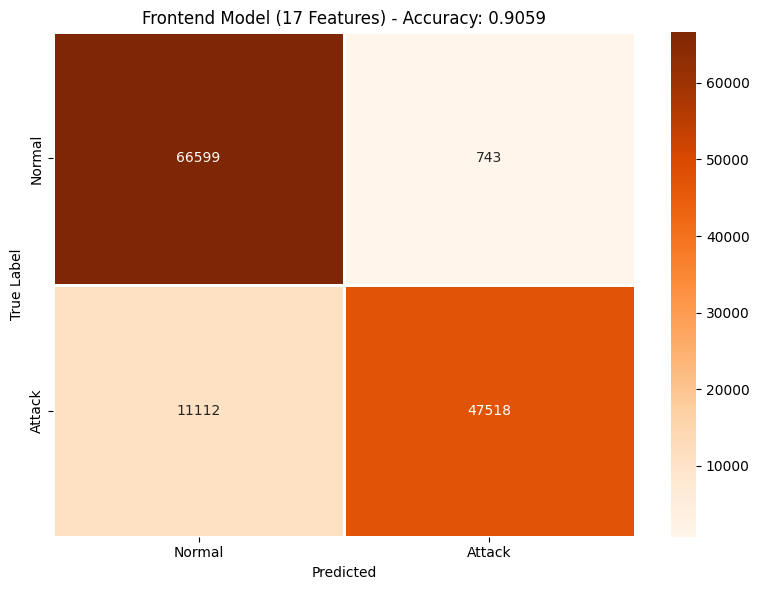

In [19]:
# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(frontend_cm, annot=True, fmt="d", cmap="Oranges", linewidths=2,
            xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.xlabel("Predicted")
plt.ylabel("True Label")
plt.title(f"Frontend Model (17 Features) - Accuracy: {frontend_acc:.4f}")
plt.tight_layout()
plt.show()

## Save Model

In [20]:
# Save Frontend Model
print(f"\n{'='*60}")
print("💾 SAVING FRONTEND MODEL")
print(f"{'='*60}\n")

# Save model
joblib.dump(frontend_model, 'isolation_forest_frontend.pkl')
print("✅ Frontend model saved as 'isolation_forest_frontend.pkl'")

# Save frontend features list
joblib.dump(frontend_features, 'frontend_features.pkl')
print("✅ Frontend features saved as 'frontend_features.pkl'")

# Save scaler and encoder
joblib.dump(scaler, 'scaler_frontend.pkl')
print("✅ Scaler saved as 'scaler_frontend.pkl'")

joblib.dump(encoder, 'encoder_frontend.pkl')
print("✅ Encoder saved as 'encoder_frontend.pkl'")

joblib.dump(freq_encoding, 'freq_encoding_frontend.pkl')
print("✅ Frequency encoding saved as 'freq_encoding_frontend.pkl'")

# Save as text file for reference
with open('frontend_features.txt', 'w') as f:
    f.write("Frontend Features for Production Model\n")
    f.write("="*50 + "\n\n")
    for i, feat in enumerate(frontend_features, 1):
        f.write(f"{i:2d}. {feat}\n")
print("✅ Feature list saved as 'frontend_features.txt'")

print(f"\n📌 PRODUCTION READY:")
print(f"   ✓ Features: 17 (68.5% reduction)")
print(f"   ✓ Model: isolation_forest_frontend.pkl")
print(f"   ✓ Scaler: scaler_frontend.pkl")
print(f"   ✓ Encoder: encoder_frontend.pkl")
print(f"   ✓ Freq Encoding: freq_encoding_frontend.pkl")
print(f"   ✓ Accuracy: {frontend_acc:.4f}")
print(f"   ✓ ROC-AUC: {frontend_auc:.4f}")


💾 SAVING FRONTEND MODEL

✅ Frontend model saved as 'isolation_forest_frontend.pkl'
✅ Frontend features saved as 'frontend_features.pkl'
✅ Scaler saved as 'scaler_frontend.pkl'
✅ Encoder saved as 'encoder_frontend.pkl'
✅ Frequency encoding saved as 'freq_encoding_frontend.pkl'
✅ Feature list saved as 'frontend_features.txt'

📌 PRODUCTION READY:
   ✓ Features: 17 (68.5% reduction)
   ✓ Model: isolation_forest_frontend.pkl
   ✓ Scaler: scaler_frontend.pkl
   ✓ Encoder: encoder_frontend.pkl
   ✓ Freq Encoding: freq_encoding_frontend.pkl
   ✓ Accuracy: 0.9059
   ✓ ROC-AUC: 0.8997
